## Задача 1

Реализовать класс для работы с линейной регрессией

In [30]:
import pandas as pd
import numpy as np

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2'
        нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size

        self.coefs_ = None  # Веса для признаков
        self.intercept_ = None  # Свободный член (bias)
        self.n_features = None  # Количество признаков

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        """
        Обучение модели линейной регрессии.

        Parameters
        ----------
        X : pandas.DataFrame
            Матрица признаков размера (n_samples, n_features)
        y : pandas.DataFrame
            Вектор целевых значений размера (n_samples, 1)
        """
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values.reshape(-1, 1)

        n_samples = X.shape[0]
        self.n_features = X.shape[1]

        ones = np.ones((n_samples, 1))
        X_1 = np.hstack((ones, X))

        learning_rate = 0.01
        n_iter = 1000

        # Матричный метод
        if self.weight_calc == 'matrix':

          XTX = X_1.T @ X_1

          if self.regularization == 'l2' and self.lambda_2 is not None:
            ident_matrix = np.eye(XTX.shape[0])
            lambda_matrix = self.lambda_2 * ident_matrix
            lambda_matrix[0,0] = 0
            XTX = XTX + lambda_matrix

          w = np.linalg.pinv(XTX) @ X_1.T @ y

          self.intercept_ = w[0]
          self.coefs_ = w[1:].flatten()

          # Градиентный спуск
        elif self.weight_calc == 'gd':
          self.coefs_ = np.random.randn(self.n_features, 1) * 0.01
          self.intercept_ = np.array([[np.random.randn() * 0.01]])

          w = np.vstack([self.intercept_, self.coefs_])

          for i in range(n_iter):
            y_pred = X_1 @ w
            err = y_pred - y

            grad = (2/n_samples) * X_1.T @ err

            if self.regularization == 'l1' and self.lambda_1 is not None:
              reg_grad = self.lambda_1 * np.sign(w)
              reg_grad[0] = 0
              grad += reg_grad

            elif self.regularization == 'l2' and self.lambda_2 is not None:
              reg_grad = 2 * self.lambda_2 * w
              reg_grad[0] = 0
              grad += reg_grad

            elif self.regularization == 'l1l2' and self.lambda_1 is not None and self.lambda_2 is not None:
              reg_grad = self.lambda_1 * np.sign(w) + 2 * self.lambda_2 * w
              reg_grad[0] = 0
              grad += reg_grad

            w -= learning_rate * grad
          self.intercept_ = w[0]
          self.coefs_ = w[1:].flatten()

        #Стохастический градиентный спуск
        elif self.weight_calc == 'sgd':
            self.coefs_ = np.random.randn(self.n_features, 1) * 0.01
            self.intercept_ = np.array([[np.random.randn() * 0.01]])

            w = np.vstack([self.intercept_, self.coefs_])

            indices = np.arange(n_samples)

            for e in range(n_iter):
              np.random.shuffle(indices)
              X_shuf = X[indices]
              y_shuf = y[indices]

              for i in range(0, n_samples, self.batch_size):
                batch_end = min(i + self.batch_size, n_samples)
                X_batch = X_shuf[i:batch_end]
                y_batch = y_shuf[i:batch_end]

                batch_size_cur = X_batch.shape[0]
                X_batch_1 = np.hstack((np.ones((batch_size_cur, 1)), X_batch))

                y_pred_batch = X_batch_1 @ w

                err_batch = y_pred_batch - y_batch

                grad = (2/batch_size_cur) * X_batch_1.T @ err_batch

                if self.regularization == 'l1' and self.lambda_1 is not None:
                  reg_grad = self.lambda_1 * np.sign(w)
                  reg_grad[0] = 0
                  grad += reg_grad

                elif self.regularization == 'l2' and self.lambda_2 is not None:
                  reg_grad = 2 * self.lambda_2 * w
                  reg_grad[0] = 0
                  grad += reg_grad

                elif self.regularization == 'l1l2' and self.lambda_1 is not None and self.lambda_2 is not None:
                  reg_grad = self.lambda_1 * np.sign(w) + 2 * self.lambda_2 * w
                  reg_grad[0] = 0
                  grad += reg_grad

                w -= learning_rate * grad
            self.intercept_ = w[0]
            self.coefs_ = w[1:].flatten()



        return self

    def predict(self, X: np.array, ss=True):
        if self.coefs_ is None:
          raise ValueError("Вызовите fit(). Модель не обучена.")

        X = X.values if isinstance(X, pd.DataFrame) else X
        y_pred = X @ self.coefs_ + self.intercept_

        return y_pred.flatten()

    def score(self, X: np.array, y: np.array):
        y_pred = self.predict(X)
        y = y.values.reshape(-1, 1)

        res = np.sum((y - y_pred) ** 2)
        tot = np.sum((y - np.mean(y)) ** 2)

        r2 = 1 - (res / tot)

        return r2

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [6]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['Used_fiat_500_in_Italy_dataset (1).csv']))

Saving Used_fiat_500_in_Italy_dataset (1).csv to Used_fiat_500_in_Italy_dataset (1).csv


In [43]:
df1 = df
df.describe()

,engine_power,age_in_days,km,previous_owners,lat,lon,price
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,73.015789,3310.265789,102196.250000,1.510526,44.257712,10.742644,5881.655263
std,9.984672,1437.555063,47115.355234,0.560244,1.767518,2.167753,2170.617946
min,69.000000,91.000000,4981.000000,1.000000,37.510872,7.320720,2890.000000
25%,69.000000,3097.250000,76611.750000,1.000000,43.514196,9.159140,4600.000000
50%,69.000000,3927.000000,112000.000000,1.000000,45.069679,10.301505,5000.000000
75%,69.000000,4322.000000,135000.000000,2.000000,45.556942,12.346788,5500.000000
max,101.000000,4719.000000,259000.000000,4.000000,46.781651,18.168011,15900.000000


In [42]:
df.head()

,engine_power,age_in_days,km,previous_owners,lat,lon,price
0,69,4474,56779,2,45.071079,7.46403,4490
1,69,2708,160000,1,45.069679,7.70492,4500
2,69,3470,170000,2,45.514599,9.28434,4500
3,69,3288,132000,2,41.903221,12.49565,4700
4,69,3712,124490,2,45.532661,9.03892,4790


In [10]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [45]:
X = df.drop(['model', 'transmission', 'price'], axis=1)
y = df['price']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Количество признаков: {X_train.shape[1]}")

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценивает модель по различным метрикам"""
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    predict_time = time.time() - start_time

    r2 = r2_score(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)

    if hasattr(model, 'coef_'):
        coefs = model.coef_
    elif hasattr(model, 'coefs_'):
        coefs = model.coefs_.flatten()
    else:
        coefs = None

    return {
        'model_name': model_name,
        'r2': r2,
        'mse': mse,
        'train_time': train_time,
        'predict_time': predict_time,
        'coefs': coefs
    }

results = []


mlr_simple = MyLinearRegression(regularization=None, weight_calc='matrix')
results.append(evaluate_model(mlr_simple, X_train, X_test, y_train, y_test,
                             'MyLR (no reg, matrix)'))

mlr_ridge = MyLinearRegression(regularization='l2', weight_calc='matrix', lambda_2=1.0)
results.append(evaluate_model(mlr_ridge, X_train, X_test, y_train, y_test,
                             'MyLR (L2 reg, matrix)'))

mlr_ridge_gd = MyLinearRegression(regularization='l2', weight_calc='gd', lambda_2=1.0)
results.append(evaluate_model(mlr_ridge_gd, X_train, X_test, y_train, y_test,
                             'MyLR (L2 reg, GD)'))

mlr_lasso = MyLinearRegression(regularization='l1', weight_calc='gd', lambda_1=0.1)
results.append(evaluate_model(mlr_lasso, X_train, X_test, y_train, y_test,
                             'MyLR (L1 reg, GD)'))

mlr_elastic = MyLinearRegression(regularization='l1l2', weight_calc='gd',
                                lambda_1=0.1, lambda_2=0.1)
results.append(evaluate_model(mlr_elastic, X_train, X_test, y_train, y_test,
                             'MyLR (L1L2 reg, GD)'))

mlr_sgd = MyLinearRegression(regularization='l2', weight_calc='sgd',
                            lambda_2=1.0, batch_size=32)
results.append(evaluate_model(mlr_sgd, X_train, X_test, y_train, y_test,
                             'MyLR (L2 reg, SGD)'))


sk_simple = LinearRegression()
results.append(evaluate_model(sk_simple, X_train, X_test, y_train, y_test,
                             'Sklearn LinearRegression'))

sk_ridge = Ridge(alpha=1.0)
results.append(evaluate_model(sk_ridge, X_train, X_test, y_train, y_test,
                             'Sklearn Ridge'))

sk_lasso = Lasso(alpha=0.1)
results.append(evaluate_model(sk_lasso, X_train, X_test, y_train, y_test,
                             'Sklearn Lasso'))

sk_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
results.append(evaluate_model(sk_elastic, X_train, X_test, y_train, y_test,
                             'Sklearn ElasticNet'))

results_df = pd.DataFrame(results)

comparison_table = results_df.drop('coefs', axis=1)
comparison_table['r2'] = comparison_table['r2'].round(4)
comparison_table['mse'] = comparison_table['mse'].round(2)
comparison_table['train_time'] = comparison_table['train_time'].round(6)
comparison_table['predict_time'] = comparison_table['predict_time'].round(6)
comparison_table



Train set: (304, 6), Test set: (76, 6)
Количество признаков: 6


,model_name,r2,mse,train_time,predict_time
0,"MyLR (no reg, matrix)",0.8934,544270.14,0.000536,0.000059
1,"MyLR (L2 reg, matrix)",0.8932,545042.20,0.000426,0.000051
2,"MyLR (L2 reg, GD)",0.7430,1311921.43,0.026633,0.000076
3,"MyLR (L1 reg, GD)",0.8932,544918.51,0.027878,0.000076
4,"MyLR (L1L2 reg, GD)",0.8851,586316.62,0.031877,0.000072
5,"MyLR (L2 reg, SGD)",0.7461,1296104.27,0.481527,0.000076
6,Sklearn LinearRegression,0.8934,544270.14,0.002928,0.003205
7,Sklearn Ridge,0.8932,545042.20,0.005052,0.003124
8,Sklearn Lasso,0.8934,544323.65,0.002709,0.003060
9,Sklearn ElasticNet,0.8900,561319.89,0.002849,0.003157


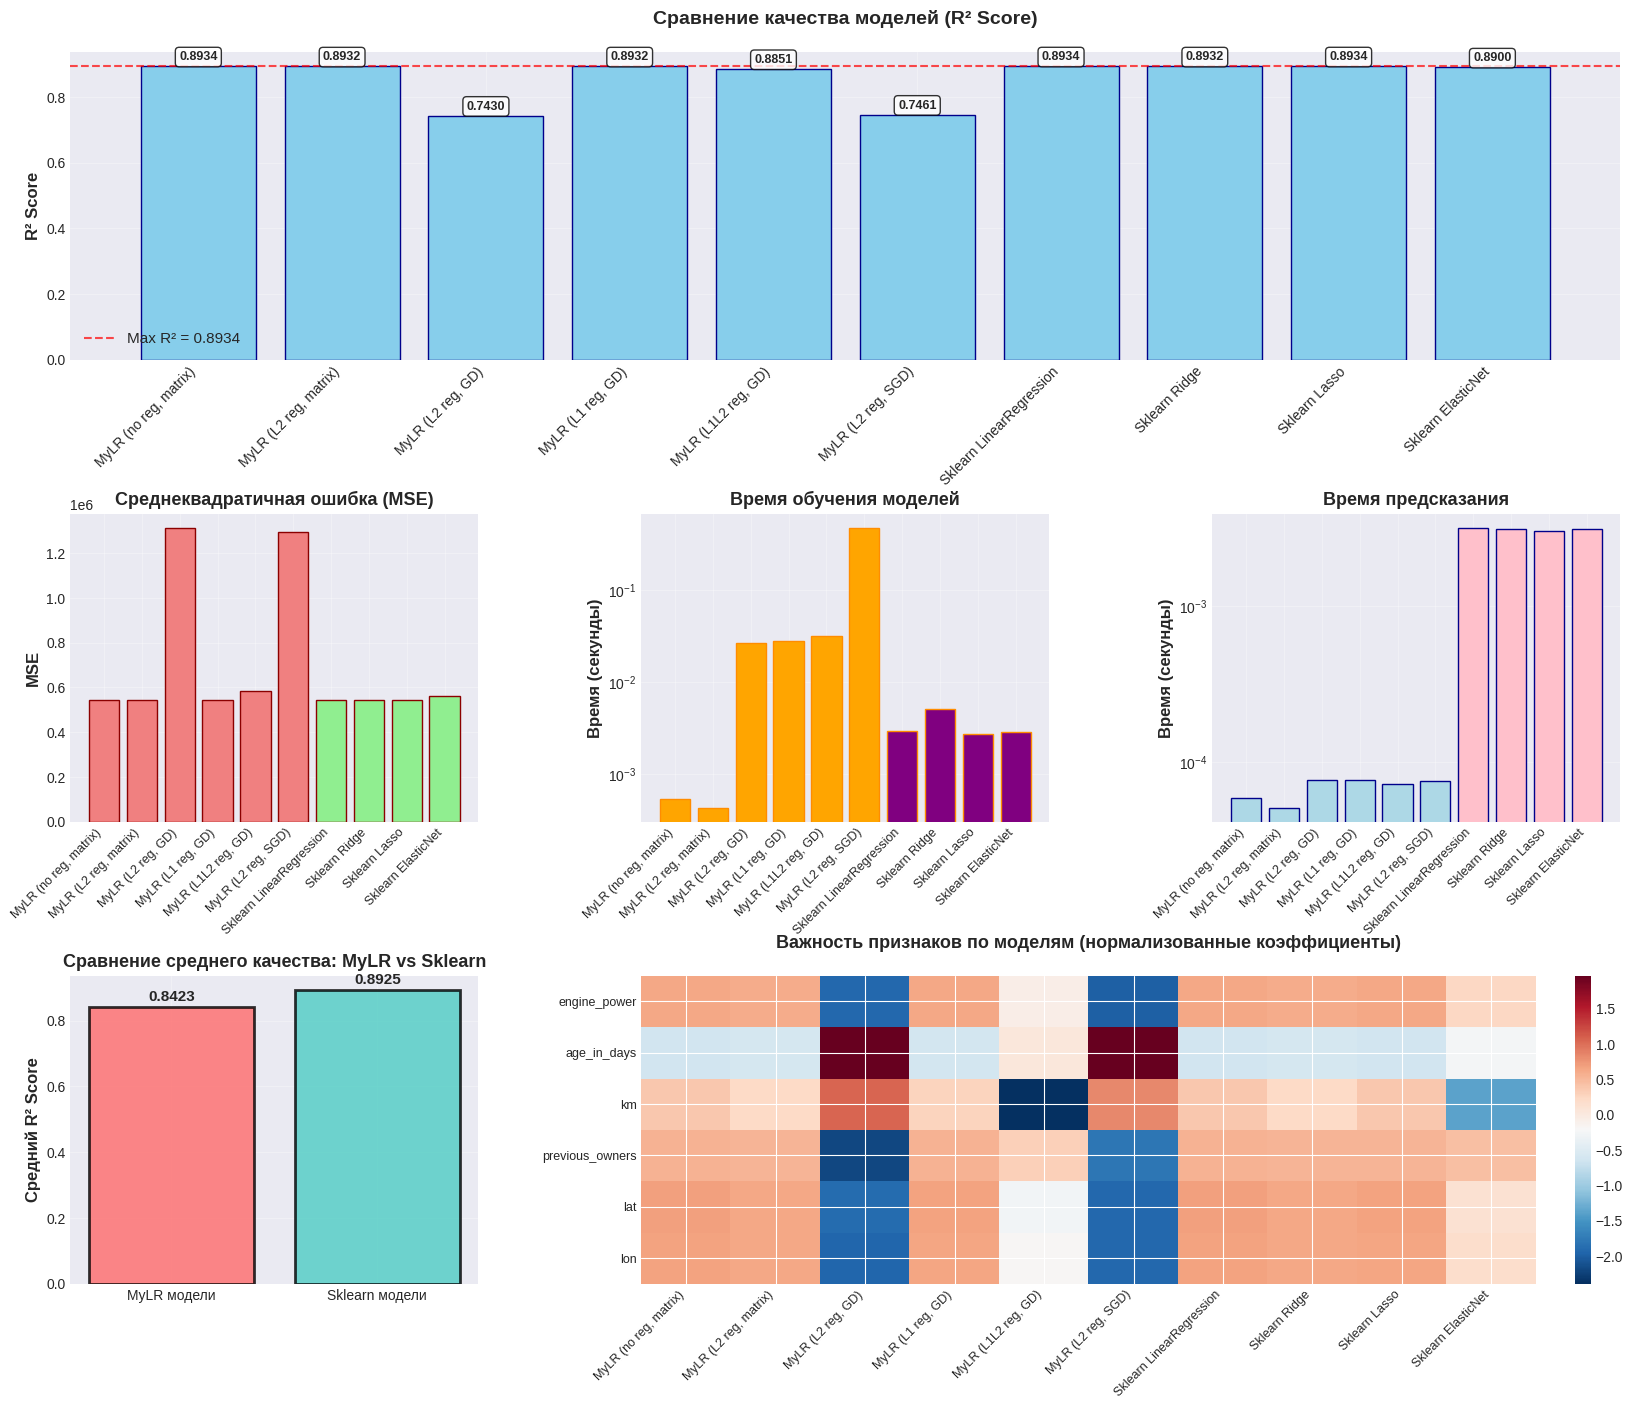

In [51]:
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig = plt.figure(figsize=(20, 16))

gs = GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.4)

# 1. Сравнение R² всех моделей
ax1 = fig.add_subplot(gs[0, :])
bars = ax1.bar(results_df['model_name'], results_df['r2'], color='skyblue', edgecolor='darkblue', linewidth=1)
max_r2 = results_df['r2'].max()
ax1.axhline(y=max_r2, color='r', linestyle='--', alpha=0.7, label=f'Max R² = {max_r2:.4f}')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Сравнение качества моделей (R² Score)', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticklabels(results_df['model_name'], rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

for bar, r2 in zip(bars, results_df['r2']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{r2:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# 2. Сравнение MSE
ax2 = fig.add_subplot(gs[1, 0])
colors_mse = ['lightcoral' if 'MyLR' in name else 'lightgreen' for name in results_df['model_name']]
bars_mse = ax2.bar(results_df['model_name'], results_df['mse'], color=colors_mse, edgecolor='darkred', linewidth=1)
ax2.set_ylabel('MSE', fontsize=12, fontweight='bold')
ax2.set_title('Среднеквадратичная ошибка (MSE)', fontsize=13, fontweight='bold')
ax2.set_xticklabels(results_df['model_name'], rotation=45, ha='right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Время обучения
ax3 = fig.add_subplot(gs[1, 1])
colors_train = ['orange' if 'MyLR' in name else 'purple' for name in results_df['model_name']]
bars_train = ax3.bar(results_df['model_name'], results_df['train_time'], color=colors_train, edgecolor='darkorange', linewidth=1)
ax3.set_ylabel('Время (секунды)', fontsize=12, fontweight='bold')
ax3.set_title('Время обучения моделей', fontsize=13, fontweight='bold')
ax3.set_xticklabels(results_df['model_name'], rotation=45, ha='right', fontsize=9)
ax3.set_yscale('log')  # Логарифмическая шкала для лучшей визуализации
ax3.grid(True, alpha=0.3)

# 4. Время предсказания
ax4 = fig.add_subplot(gs[1, 2])
colors_predict = ['lightblue' if 'MyLR' in name else 'pink' for name in results_df['model_name']]
bars_predict = ax4.bar(results_df['model_name'], results_df['predict_time'], color=colors_predict, edgecolor='darkblue', linewidth=1)
ax4.set_ylabel('Время (секунды)', fontsize=12, fontweight='bold')
ax4.set_title('Время предсказания', fontsize=13, fontweight='bold')
ax4.set_xticklabels(results_df['model_name'], rotation=45, ha='right', fontsize=9)
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# 5. Сравнение MyLR и Sklearn моделей (группировка)
ax5 = fig.add_subplot(gs[2, 0])
my_lr_mask = results_df['model_name'].str.contains('MyLR')
sklearn_mask = results_df['model_name'].str.contains('Sklearn')

my_lr_r2 = results_df.loc[my_lr_mask, 'r2'].mean() if my_lr_mask.any() else 0
sklearn_r2 = results_df.loc[sklearn_mask, 'r2'].mean() if sklearn_mask.any() else 0

categories = ['MyLR модели', 'Sklearn модели']
values = [my_lr_r2, sklearn_r2]
colors_group = ['#FF6B6B', '#4ECDC4']
bars_group = ax5.bar(categories, values, color=colors_group, edgecolor='black', linewidth=2, alpha=0.8)
ax5.set_ylabel('Средний R² Score', fontsize=12, fontweight='bold')
ax5.set_title('Сравнение среднего качества: MyLR vs Sklearn', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)

for bar, value in zip(bars_group, values):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 6. Heatmap важности признаков (для моделей с коэффициентами)
ax6 = fig.add_subplot(gs[2, 1:])

coef_matrix = []
model_names_for_heatmap = []
for idx, row in results_df.iterrows():
    if row['coefs'] is not None and not np.isnan(row['coefs']).any():
        coef_matrix.append(row['coefs'])
        model_names_for_heatmap.append(row['model_name'])

if coef_matrix:
    coef_matrix = np.array(coef_matrix)

    coef_normalized = (coef_matrix - coef_matrix.mean(axis=0)) / (coef_matrix.std(axis=0) + 1e-10)

    im = ax6.imshow(coef_normalized.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')

    ax6.set_xticks(range(len(model_names_for_heatmap)))
    ax6.set_xticklabels(model_names_for_heatmap, rotation=45, ha='right', fontsize=9)
    ax6.set_yticks(range(len(X.columns)))
    ax6.set_yticklabels(X.columns, fontsize=9)
    ax6.set_title('Важность признаков по моделям (нормализованные коэффициенты)',
                  fontsize=13, fontweight='bold', pad=20)

    plt.colorbar(im, ax=ax6, orientation='vertical', fraction=0.046, pad=0.04)
else:
    ax6.text(0.5, 0.5, 'Коэффициенты недоступны\nдля визуализации',
             ha='center', va='center', fontsize=12, transform=ax6.transAxes)
    ax6.set_title('Важность признаков', fontsize=13, fontweight='bold')

На основе анализа результатов сравнения ручной и машинной реализации линейной регрессии можно сделать следующие ключевые выводы.

Качество моделей, измеряемое через R², показывает, что лучшие результаты достигаются матричными методами. Ручная реализация без регуляризации и sklearn-модели LinearRegression и Lasso демонстрируют одинаково высокий показатель 0.8934, что подтверждает корректность математической реализации. Однако градиентные методы, особенно SGD, показывают значительно худшие результаты около 0.74-0.75, что указывает на проблемы со сходимостью или настройкой гиперпараметров.

В скорости обучения наблюдается выраженное преимущество ручных матричных методов — они оказываются в 10 раз быстрее sklearn-реализаций, достигая времени порядка 0.0005 секунд. Время предсказания у ручных моделей также на два порядка быстрее. При этом градиентный спуск, особенно в SGD-реализации, оказывается самым медленным, уступая даже оптимизированным библиотечным методам.

Эффективность регуляризации варьируется в зависимости от метода оптимизации. L2-регуляризация практически не влияет на качество при использовании матричного подхода, но значительно ухудшает результаты в градиентных методах. ElasticNet в ручной реализации показывает несколько худшие результаты по сравнению с sklearn-аналогом.

На представленном heatmap видно, что распределение коэффициентов по признакам достаточно однородное между различными моделями. Это указывает на несколько важных аспектов:

- Стабильность важности признаков — большинство моделей согласуются в оценке влияния различных предикторов на целевую переменную (цену автомобилей). Отсутствие резких расхождений между моделями говорит о том, что данные достаточно хорошо структурированы и модели не "ловят шум".

- Слабая регулярирующая роль L1/L2 — тот факт, что модели с регуляризацией показывают очень похожие коэффициенты с обычной линейной регрессией, свидетельствует о том, что в данных нет выраженной мультиколлинеарности или избыточности признаков, требующей жесткого регуляризирующего воздействия.

- Ограниченная эффективность отбора признаков через Lasso — поскольку Sklearn Lasso показывает практически те же коэффициенты, что и обычная регрессия, это означает, что ни один из признаков не был полностью обнулен. Все используемые предикторы вносят ощутимый вклад в прогноз.